# Problem 1

What is $ \lim_{\epsilon\to0} \int_\epsilon^1 x^{-1} \cos(x^{-1} \log x) dx $ ? 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import pi
from numpy import cos, log
from tqdm import tqdm_notebook as tqdm

Let $f(x) =  x^{-1}  \cos(x^{-1} \log x) $ be our integrand.

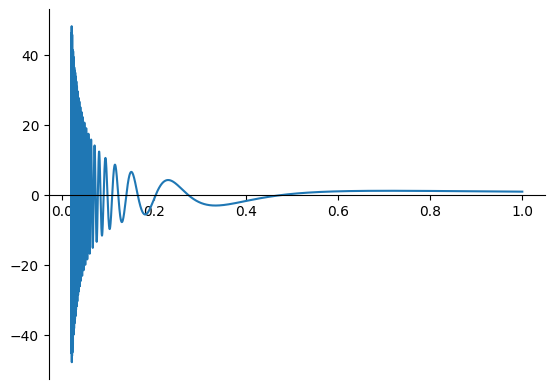

In [2]:
f = lambda x: cos(log(x)/x)/x
x = np.linspace(0.02,1,10000)
y = f(x)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.plot(x,y)
plt.show()

As we can see, the integrand is very ill-behaved and oscillates a lot - therefore typical numerical integration algorithms may not work that well. Nonetheless, we will try that as a first attempt.

## Method 1: Integrating as-is

In [3]:
from scipy import integrate
integrate.quad(f,0,1)

/tmp/ipykernel_88714/4081173682.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f,0,1)


(1.2716741383488144, 1.9276166879370535)

As expected, this does not work as the integral is not well-behaved (note the given warning and that the error estimate is larger than the value it got for the integral itself).

However, since the integral is well behaved between its zeros, we can have points $ 0 = x_0 < x_1 < \cdots < x_{N-1}  < x_N = 1 $ where $f(x_i) = 0 $ for $0 < i < N$ .

We therefore have:

$$ \int_{0}^1 f(x) dx = \sum_{i=0}^{N-1} \left( \int_{x_i}^{x_{i+1}} f(x) dx \right) $$
 
where the integrand over each $[x_{i}, x_{i+1}]$ is well-behaved. We have:


$$\begin{align*}
f(x) = 0 &\implies \cos(x^{-1} \log{x}) = 0 \\
&\implies x^{-1} \log{x} = \pi\left(n-\frac{1}{2}\right), n \in \mathbb{Z}_{<0} \\
&\implies x = e^{-W\left(\frac{\pi}{2} - n\pi\right)}
\end{align*}$$

where $ W(x) $ is the [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function). An implementation of this is below (note that we only use floating point precision):

In [4]:
from scipy.special import lambertw
from math import pi, exp

def nth_zero(n):
    return exp(-lambertw(pi/2-n*pi)).real


intervals = [integrate.quad(f, nth_zero(i), nth_zero(i+1)) for i in tqdm(range(0, -100000, -1)) ]
integral_val = sum([i[0] for i in intervals])
error = sum([i[1] for i in intervals])

integral_val, error

/tmp/ipykernel_88714/502815136.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  intervals = [integrate.quad(f, nth_zero(i), nth_zero(i+1)) for i in tqdm(range(0, -100000, -1)) ]


  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_88714/502815136.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return exp(-lambertw(pi/2-n*pi)).real


(0.32336452967614154, 9.410465197082566e-13)

Note that there is a problem with this approach: namely, the closer that we get to 0, the more the integrand diverges - therefore, the more accurate value we want, the more subintervals we need to integrate over. We also have to worry about the error terms of calculating the functions of each of the values, so it would be nicer if we calculated just one integral instead.

**EXERCISE**: Is there any way we can bound the error with this method? We have:

$$ \int_0^1 f(x) dx \approx \int_\epsilon^1 f(x) dx $$ however, what bounds can we place on the error term $\int_0^\epsilon f(x) dx  $ ?

## Method 2: Complex integration

We have that

$$ \begin{align*} 
\int_0^1 \frac{\cos(x^{-1} \log{x})}{x} dx &= \int_0^1 \Re\left(\frac{e^{i(\log{z}/z)}}{z}\right) \\
& = \int_0^1 \Re(z^{-1+i/z}) \\
&= \Re\left(\int_0^1 z^{-1+i/z}\right) \\
&= \Re\left(\int_C z^{-1+i/z}\right) \\
\\ 
\end{align*}
$$ 

where $C$ is a contour from $z = 0 $ to $z = 1 $ such that the integrand is analytic on the whole contour. 

We use a semicircle oriented clockwise centered at $z = \frac{1}{2}  $ on the complex plane with a radius of $\frac{1}{2} $ . This can be parametrized with the map 
$ r: [0, \pi] \to \mathbb{C} \;,  r(\theta) = \frac{1}{2} - \frac{1}{2}e^{-i\theta}$

Substituting this in, we have our integral is

$$ \Re\left(\int_C z^{-1+i/z}\right) = \Re \left( \int_0^\pi   \frac{ie^{-it}}{1-e^{-it}} \left(\frac{1-e^{-it}}{2}\right)^{\frac{2i}{1-e^{-it}}} dt  \right)   $$

In [5]:
from numpy import exp

ex = lambda t: exp(1j*t)
integrand = lambda t: 1j*ex(-t)/(1-ex(-t)) * (0.5*(1-ex(-t)))**(2j/(1-ex(-t)))

%time integrate.quad(integrand,0,pi)

CPU times: user 3.86 ms, sys: 240 µs, total: 4.1 ms
Wall time: 5.6 ms


/home/husnain/Desktop/RandomProjects/100-Digit-Challenge/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:523: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(0.3233674316777749, 5.940167106104359e-09)

Note that this is much faster than the previous method as there is only one integral to evaluate - we also get the 10 digits that we need. We can get further digits by using an extended precision library like `mpmath`:

In [6]:
from mpmath import mp, mpf, mpc, exp, quad, pi
mp.dps = 1000
ex = lambda t: exp(mpc(0,1)*t)
integrand = lambda t: mpc(0,1)*ex(-t)/(1-ex(-t)) * (mpf("0.5")*(1-ex(-t)))**(mpc(0,2)/(1-ex(-t)))
%time result, error = quad(integrand, [0,pi], error=True)
print(result.real, error)

CPU times: user 9min 21s, sys: 1.21 s, total: 9min 22s
Wall time: 9min 33s
0.32336743167777876139937008795217044665104662572546966168103644343179033721067289443193037046410245138028052733121715128433295510033435188538143459338499591004962031872302437553058503268678260848141436210082845447223254331974232895622083830360518061381702288759277962238894141948088977862776567200916363254809300626123688307095156172596262271091227961818486264925203544258058783035128789227135061769725043634273242780626981954599359379349487033770039938878958444941938532524701051263491411668692808429670505450842283874069074200475180220172475541092305833604470950458175969464897886301677684260917361445085967504940115969318169715870285721071580528889123103966740195477112287059791090468098755993831428538993148977233485367694543683615578685262852463455374636167870336055419899105303373002905595204909101381319521275325199677051881007836511188772835687475009609176911865529334596642093059266995096076632168382511609990025691